In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import IPython
%matplotlib notebook
#pd.options.display.max_rows = None
#pd.options.display.max_columns = None


In [2]:
NUM_MELHORES = 40

In [3]:
df_melhores = pd.read_feather('dados/melhores.feather')
df_turmas = pd.read_feather('dados/turmas2018.feather')
df_escolas = pd.read_feather('dados/escolas_rio_2018.feather')

In [4]:
df_enem_rio = pd.read_feather('dados/enem_rio_2018.feather')

## Nota final
Abaixo pode-se personalizar o cálculo de nota final. pondero pelas notas mais importantes.

O Inep costuma considerar a redação como tendo um peso igual às outras disciplinas. 

Algumas universidades consideram um peso distinto de acordo com a disciplina

### Pesos UFRJ

Referência dos [pesos da UFRJ](https://oglobo.globo.com/sociedade/educacao/ufrj-usara-pesos-diferentes-em-provas-do-enem-2011-para-acesso-aos-cursos-de-graduacao-2865665).

- Redação: peso 3 (mínimo 300)
- Ciência da Computação, Ciências Atuariais, Engenharias, Estatística, Matemática e Química Industrial
    - Matemática tem peso 4
- Ciências Econômicas, Geologia e Meteorologia
    - Matemática peso 3
- Engenharias e Química Industrial
    - Ciências da Natureza: peso 4
- Geologia
    - Ciências da Natureza: peso 3
- Humanas
    - Ciências Humanas e Linguagens: peso 2



In [5]:
notas_cols = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', ]
notas_pesos =(1, 1, 1, 1, 4)


In [6]:
media_ponderada = lambda notas: np.average(notas, weights=notas_pesos)

df_enem_rio['nota_final'] = df_enem_rio\
  .loc[df_enem_rio.TP_ST_CONCLUSAO == 2, notas_cols ]\
  .apply(media_ponderada, axis=1).round(0)
df_enem_rio[notas_cols+ ['nota_final']].head()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,nota_final
0,468.7,563.8,508.3,513.7,340.0,427.0
1,592.8,706.0,633.1,740.3,820.0,744.0
2,431.7,560.9,479.7,557.0,560.0,534.0
3,590.7,487.7,527.6,492.7,600.0,562.0
4,530.7,669.8,626.8,638.1,740.0,678.0


In [7]:
notas_agg = {col: (col, 'median') for col in notas_cols}
notas_agg['mediana'] = ('nota_final', 'median')
notas_agg['num'] = ('nota_final', 'count')

df_melhores = df_enem_rio.groupby('CO_ESCOLA')\
       .agg(**notas_agg).sort_values('mediana', ascending=False)
df_melhores = df_melhores[df_melhores.num > 30] #corte arbitrário, só quem tem mais de 30 alunos
df_melhores.head()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,mediana,num
CO_ESCOLA,,,,,,,
33135371,662.7,691.40,635.00,763.2,920.0,803.0,91
33062633,689.5,702.85,645.70,801.1,900.0,800.5,62
33063729,653.3,692.05,628.35,766.7,900.0,789.0,245
33176825,654.4,691.10,637.60,771.8,900.0,788.0,185
33148376,615.2,679.80,617.75,747.7,900.0,780.0,73


In [327]:
CO_SAO_BENTO = 33062633
CO_SAO_VICENTE = 33063648
CO_PARQUE = 33065837
CO_ELEVA = 33178860
CO_MUN_RIO = 3304557

In [9]:
df_melhores['CO_ESCOLA'] = df_melhores.index.astype('category')
df_melhores['rank'] = df_melhores.mediana.rank(ascending=False, method='min')

In [10]:
df_melhores = df_melhores.merge(df_escolas, left_index=True, right_on='CO_ENTIDADE').loc[:,
    ['NO_ENTIDADE',  'mediana', 'num', 'rank'] + notas_cols + ['CO_ENTIDADE']]
df_melhores

,NO_ENTIDADE,mediana,num,rank,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,CO_ENTIDADE
189289,COLEGIO CRUZEIRO - JACAREPAGUA,803.0,91,1.0,662.70,691.40,635.00,763.20,920.0,33135371
177267,COL DE SAO BENTO,800.5,62,2.0,689.50,702.85,645.70,801.10,900.0,33062633
177286,COLEGIO SANTO INACIO,789.0,245,3.0,653.30,692.05,628.35,766.70,900.0,33063729
194893,COLEGIO SANTO AGOSTINHO - UNIDADE INSTITUTO CU...,788.0,185,4.0,654.40,691.10,637.60,771.80,900.0,33176825
188313,ESCOLA PARQUE - BARRA,780.0,73,5.0,615.20,679.80,617.75,747.70,900.0,33148376
...,...,...,...,...,...,...,...,...,...,...
188256,CE COMPOSITOR MANACEIA JOSE DE ANDRADE,455.0,35,262.0,458.00,552.60,502.60,444.00,410.0,33132887
189760,CE HERBERT DE SOUZA,454.0,46,263.0,462.30,524.40,480.60,471.50,400.0,33126224
189279,CE PROFESSOR JOSE DE SOUZA MARQUES,439.0,63,264.0,447.20,556.20,527.50,499.00,360.0,33135193
189673,CIEP 303 AYRTON SENNA DA SILVA,439.0,77,264.0,453.30,556.40,506.00,502.40,380.0,33105103


In [11]:

df_enem = df_melhores[['CO_ENTIDADE']].merge(df_enem_rio, 
                     left_on='CO_ENTIDADE', right_on='CO_ESCOLA')\
          .loc[:,list(notas_cols) + ['CO_ESCOLA', 'nota_final']]
df_enem.head()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,CO_ESCOLA,nota_final
0,696.6,721.4,680.7,766.3,940.0,33135371,828.0
1,684.8,723.6,670.2,783.1,940.0,33135371,828.0
2,724.9,709.5,653.4,872.0,940.0,33135371,840.0
3,658.4,686.2,623.1,747.0,920.0,33135371,799.0
4,601.7,659.8,591.8,754.0,920.0,33135371,786.0


In [12]:
my_order = df_melhores.head(NUM_MELHORES).NO_ENTIDADE

Ajustar no gráfico abaixo:

- diminuir nomes de escola muito grandes


In [13]:
df_melhores['rotulo'] = df_melhores.loc[:,['NO_ENTIDADE', 'num', 'rank']].apply(lambda x: '{:>s} {:03d}/{:>2.0f}'.format(x[0].title(), x[1], x[2]), axis=1)

In [14]:
df_melhores

,NO_ENTIDADE,mediana,num,rank,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,CO_ENTIDADE,rotulo
189289,COLEGIO CRUZEIRO - JACAREPAGUA,803.0,91,1.0,662.70,691.40,635.00,763.20,920.0,33135371,Colegio Cruzeiro - Jacarepagua 091/ 1
177267,COL DE SAO BENTO,800.5,62,2.0,689.50,702.85,645.70,801.10,900.0,33062633,Col De Sao Bento 062/ 2
177286,COLEGIO SANTO INACIO,789.0,245,3.0,653.30,692.05,628.35,766.70,900.0,33063729,Colegio Santo Inacio 245/ 3
194893,COLEGIO SANTO AGOSTINHO - UNIDADE INSTITUTO CU...,788.0,185,4.0,654.40,691.10,637.60,771.80,900.0,33176825,Colegio Santo Agostinho - Unidade Instituto Cu...
188313,ESCOLA PARQUE - BARRA,780.0,73,5.0,615.20,679.80,617.75,747.70,900.0,33148376,Escola Parque - Barra 073/ 5
...,...,...,...,...,...,...,...,...,...,...,...
188256,CE COMPOSITOR MANACEIA JOSE DE ANDRADE,455.0,35,262.0,458.00,552.60,502.60,444.00,410.0,33132887,Ce Compositor Manaceia Jose De Andrade 035/262
189760,CE HERBERT DE SOUZA,454.0,46,263.0,462.30,524.40,480.60,471.50,400.0,33126224,Ce Herbert De Souza 046/263
189279,CE PROFESSOR JOSE DE SOUZA MARQUES,439.0,63,264.0,447.20,556.20,527.50,499.00,360.0,33135193,Ce Professor Jose De Souza Marques 063/264
189673,CIEP 303 AYRTON SENNA DA SILVA,439.0,77,264.0,453.30,556.40,506.00,502.40,380.0,33105103,Ciep 303 Ayrton Senna Da Silva 077/264


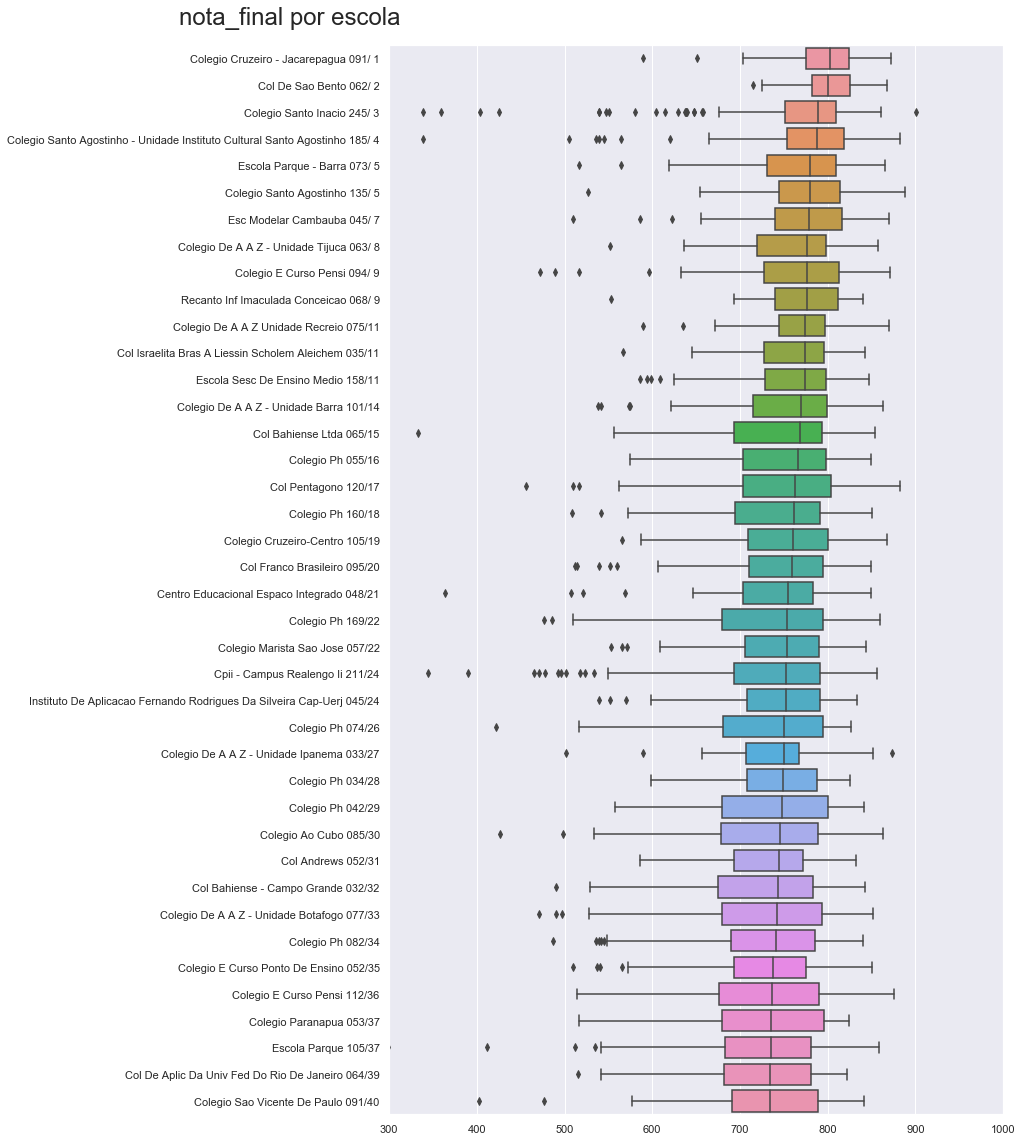

In [15]:


def compara_distribuicoes(nota):
    sns.set(rc={'figure.figsize':(11,18), 'axes.xmargin': .1})
    #sns.palplot(sns.hls_palette(8, l=.3, s=.8))
    
    nota_agrupada = nota
    if nota=='nota_final':
        nota_agrupada = 'mediana'
    
    df_top = df_melhores.sort_values(nota_agrupada, ascending=False).head(NUM_MELHORES)
    ax = sns.boxplot(data=df_enem, y='CO_ESCOLA', x=nota, orient='h'
                     ,order=df_top.CO_ENTIDADE)
    ax.set(ylabel='', xlabel='')
    plt.gcf().subplots_adjust(top=.95)
    plt.suptitle(f'{nota} por escola',x=0, size=24, );
    locs, _ = plt.yticks()
    plt.yticks(locs, df_top.rotulo);
    ax.set_xlim(300, 1000)
    

compara_distribuicoes('nota_final');


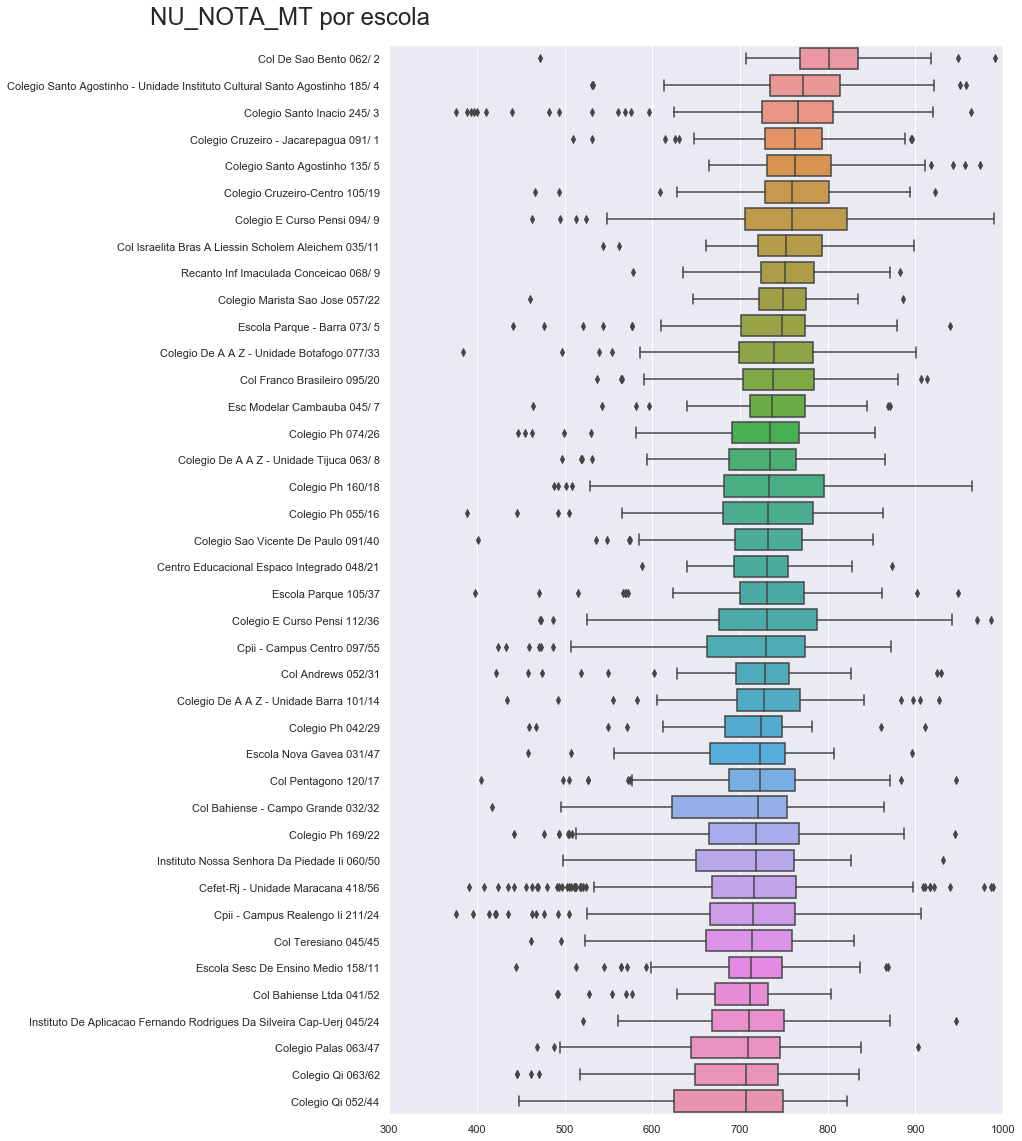

In [16]:
compara_distribuicoes('NU_NOTA_MT');

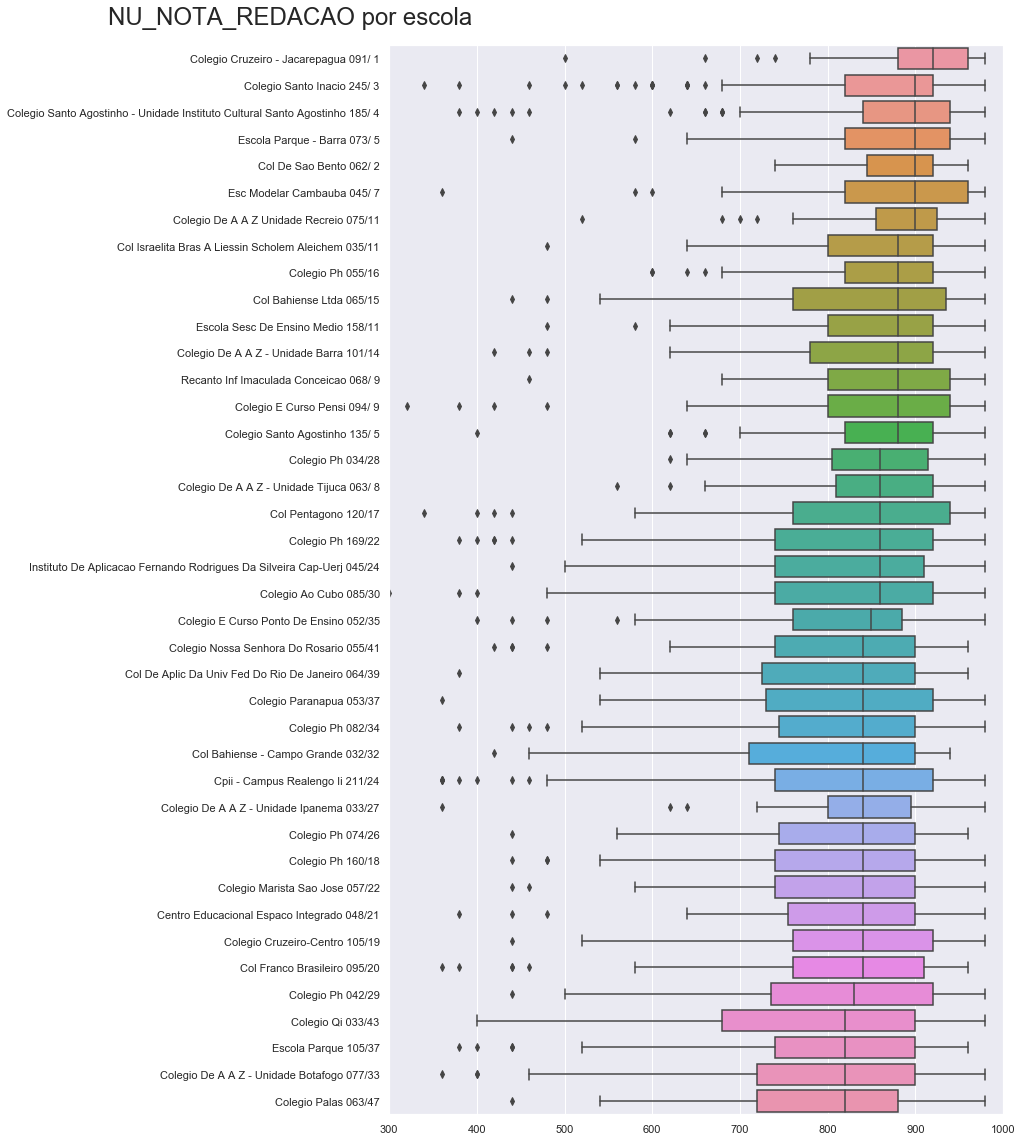

In [17]:
compara_distribuicoes('NU_NOTA_REDACAO');

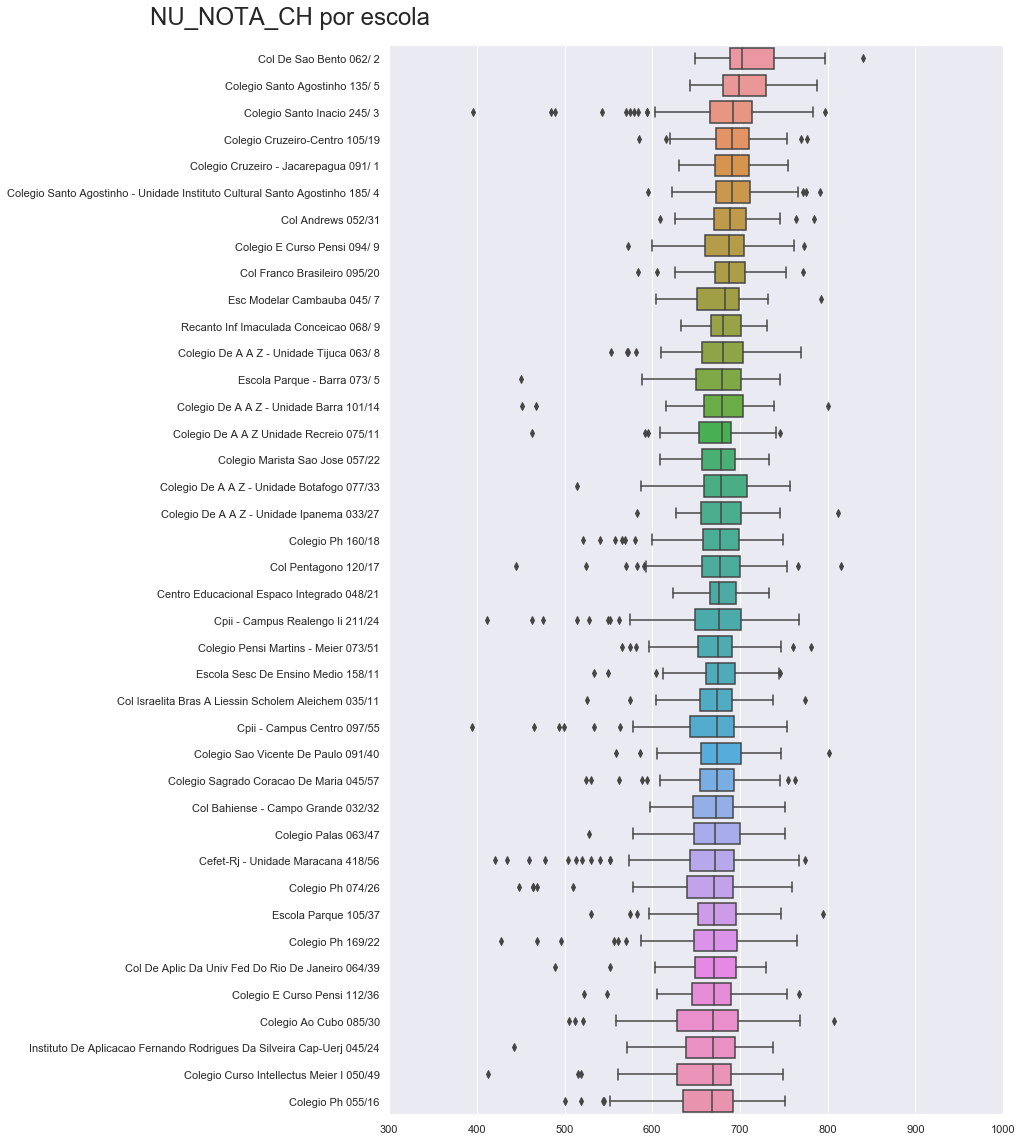

In [18]:
compara_distribuicoes('NU_NOTA_CH');

## Sobrevivência no ensino médio

Quantos dos alunos que começam o ensino médio fazem Enem?

Motivos para diminuir:
- Maus alunos são expulsos
- Maus alunos não acreditam que passarão no Enem
- Vai para universidade fora do Enem (ITAs, PUCs, USP, exterior etc.)

Motivos para aumentar:
- Crise econômica (escolas públicas)
- Bolsa para bons alunos 

### ideias
- comparar com último ano (dá ideia melhor da seleção feita pela escola)
- comparar com quem fez prova (ideia melhor de auto seleção)

In [19]:
etapa_col = 'TP_ETAPA_ENSINO'
primeiro_ano = [25,  30, 35]
# todo: tratar ensinos médios de 4 anos

In [22]:
ano = 2016

import glob
import patoolib
import os.path

def dados_turma(ano, try_rar=True):
    dir_censo = [i for i in glob.glob(f'dados/*{ano}*') if ('censo' in i or 'educacao_basica' in i) and 'zip' not in i]
    assert len(dir_censo) == 1, f'Só pode ter achado um arquivo e achou {len(dir_censo)}'

    arquivo_turmas = glob.glob(f'{dir_censo[0]}/*{ano}*/DADOS/TURMAS.*')
    if not arquivo_turmas:
        arquivo_turmas = glob.glob(f'{dir_censo[0]}/DADOS/TURMAS.*')
    
    result = [i for i in arquivo_turmas if i.lower().endswith('.csv')]
    if not result:
        result = [i for i in arquivo_turmas if i.lower().endswith('.zip')]
        if try_rar and not result:
            rar = [i for i in arquivo_turmas if i.lower().endswith('.rar')]
            if rar:
                patoolib.extract_archive(rar[0], outdir=os.path.dirname(rar[0]))
                result = dados_turma(ano, False)
                
    if result:
        result = result[0]
    else:
        result = None
    return result

for i in range(2007, 2019):
    print(">", dados_turma(i))
#estrutura diretórios bagunçados anets de 2007

patool: Extracting dados\micro_censo_escolar_2007\2007\DADOS\TURMAS.rar ...
patool: running "C:\Program Files\7-Zip\7z.EXE" x -odados\micro_censo_escolar_2007\2007\DADOS -- dados\micro_censo_escolar_2007\2007\DADOS\TURMAS.rar
patool: ... dados\micro_censo_escolar_2007\2007\DADOS\TURMAS.rar extracted to `dados\micro_censo_escolar_2007\2007\DADOS'.
> d
patool: Extracting dados\micro_censo_escolar_2008\2008\DADOS\TURMAS.rar ...
patool: running "C:\Program Files\7-Zip\7z.EXE" x -odados\micro_censo_escolar_2008\2008\DADOS -- dados\micro_censo_escolar_2008\2008\DADOS\TURMAS.rar
patool: ... dados\micro_censo_escolar_2008\2008\DADOS\TURMAS.rar extracted to `dados\micro_censo_escolar_2008\2008\DADOS'.
> d
patool: Extracting dados\micro_censo_escolar_2009\2009\DADOS\TURMAS.rar ...
patool: running "C:\Program Files\7-Zip\7z.EXE" x -odados\micro_censo_escolar_2009\2009\DADOS -- dados\micro_censo_escolar_2009\2009\DADOS\TURMAS.rar
patool: ... dados\micro_censo_escolar_2009\2009\DADOS\TURMAS.rar ext

In [303]:
series

NameError: name 'series' is not defined

In [330]:
#todo: passar isso para ledados

CO_MUN_RIO = 3304557 

col_turmas = {
    'id_etapa': {'TP_ETAPA_ENSINO', 'FK_COD_ETAPA_ENSINO'},
    'id_escola': {'CO_ENTIDADE', 'CO_ESCOLA', 'PK_COD_ENTIDADE'},
    'num_matriculas': {'NU_MATRICULAS', 'NUM_MATRICULAS', 'QT_MATRICULAS'},
    'id_municipio': {'CO_MUNICIPIO', 'FK_COD_MUNICIPIO'},
    'id_uf': {'CO_UF', 'FK_COD_ESTADO'},
}
def colunas_turmas(columns):
    result = {}
    for col in columns:
        for key, values in col_turmas.items():
            if col in values:
                result[col] = key
    return result


def le_turma(ano, escolas, serie):
    print(f"Lendo ano {ano}")
    df_teste = pd.read_csv(
            dados_turma(ano),
            sep="|",
            encoding="latin1",
            nrows=1
        )
    map_colunas = colunas_turmas(df_teste.columns)
    
    
    df_t = pd.concat((
        df_t.rename(columns=map_colunas).query('id_etapa.isin(@primeiro_ano) and id_uf == @CO_MUN_RIO')\
            .merge(escolas, left_on='id_escola', right_on='CO_ENTIDADE')
        for df_t in pd.read_csv(
            dados_turma(ano),
            sep="|",
            encoding="latin1",
            chunksize=1000, error_bad_lines=False,
            usecols=map_colunas.keys()
        )), 
        sort=True
    )
    df_t['ano'] = ano
    return df_t
    
df_primeiro_ano_turmas = pd.concat(
    (le_turma(i, df_escolas.CO_ENTIDADE, primeiro_ano) for i in range(2007, 2019)), #2007 e 2008, 2009 falharam linhas diferentes
    sort=True)
print(df_primeiro_ano_turmas.shape)
df_primeiro_ano_turmas.head()

Lendo ano 2007
Lendo ano 2008
Lendo ano 2009
Lendo ano 2010
Lendo ano 2011
Lendo ano 2012
Lendo ano 2013
Lendo ano 2014
Lendo ano 2015
Lendo ano 2016
Lendo ano 2017
Lendo ano 2018
(0, 7)


,CO_ENTIDADE,ano,id_escola,id_etapa,id_municipio,id_uf,num_matriculas


In [329]:
CO_MUN_RIO

3304557

In [ ]:
df_primeiro_ano_turmas.reset_index().to_feather('primeiro_ano.feather')

In [331]:
df_ano_um = df_primeiro_ano_turmas.groupby(['CO_ENTIDADE', 'ano'])['num_matriculas'].sum()
CO_ELEVA=33178860
df_ano_um.loc[CO_ELEVA]

KeyError: 33178860

In [38]:
with pd.option_context('display.max_columns', None):
    display(df_primeiro_ano_turmas.loc[df_primeiro_ano_turmas.CO_ENTIDADE == CO_SAO_VICENTE].head())

,ANO_CENSO,CO_CURSO_EDUC_PROFISSIONAL,CO_DISTRITO,CO_ENTIDADE,CO_MESORREGIAO,CO_MICRORREGIAO,CO_MUNICIPIO,CO_REGIAO,CO_TIPO_ATIVIDADE_1,CO_TIPO_ATIVIDADE_2,CO_TIPO_ATIVIDADE_3,CO_TIPO_ATIVIDADE_4,CO_TIPO_ATIVIDADE_5,CO_TIPO_ATIVIDADE_6,CO_UF,DESC_CATEGORIA_ESCOLA_PRIVADA,FK_COD_CURSO_PROF,FK_COD_DISTRITO,FK_COD_ESTADO,FK_COD_ETAPA_ENSINO,FK_COD_MOD_ENSINO,FK_COD_MUNICIPIO,FK_COD_TIPO_ATIVIDADE_1,FK_COD_TIPO_ATIVIDADE_2,FK_COD_TIPO_ATIVIDADE_3,FK_COD_TIPO_ATIVIDADE_4,FK_COD_TIPO_ATIVIDADE_5,FK_COD_TIPO_ATIVIDADE_6,FK_COD_TIPO_TURMA,HR_INICIAL,HR_INICIAL_MINUTO,ID_ARTES,ID_AUTONOMA,ID_AUT_ESCOLAR,ID_BIOLOGIA,ID_BRAILLE,ID_CIENCIAS,ID_COM_ALT_AUMENT,ID_CONVENIADA_PP,ID_DEPENDENCIA_ADM,ID_DIA_SEMANA_DOMINGO,ID_DIA_SEMANA_QUARTA,ID_DIA_SEMANA_QUINTA,ID_DIA_SEMANA_SABADO,ID_DIA_SEMANA_SEGUNDA,ID_DIA_SEMANA_SEXTA,ID_DIA_SEMANA_TERCA,ID_DIDATICA_METODOLOGIA,ID_DISCIPLINAS_PEDAG,ID_DISC_ATENDIMENTO_ESPECIAIS,ID_DISC_DIVERSIDADE_SOCIO_CULT,ID_DOCUMENTO_REGULAMENTACAO,ID_EDUCACAO_FISICA,ID_EDUCACAO_INDIGENA,ID_ENRIQ_CURRICULAR,ID_ENSINO_RELIGIOSO,ID_ESTUDOS_SOCIAIS,ID_FILOSOFIA,ID_FISICA,ID_FUNDAMENTOS_EDUCACAO,ID_GEOGRAFIA,ID_HISTORIA,ID_INFORMATICA_COMPUTACAO,ID_INF_ACESSIVEL,ID_LIBRAS,ID_LINGUA_LITERAT_ESPANHOL,ID_LINGUA_LITERAT_FRANCES,ID_LINGUA_LITERAT_INDIGENA,ID_LINGUA_LITERAT_INGLES,ID_LINGUA_LITERAT_OUTRA,ID_LINGUA_LITERAT_PORTUGUESA,ID_LOCALIZACAO,ID_LOCALIZACAO_DIFERENCIADA,ID_MAIS_EDUCACAO,ID_MANT_ESCOLA_PRIVADA_APAE,ID_MANT_ESCOLA_PRIVADA_EMP,ID_MANT_ESCOLA_PRIVADA_ONG,ID_MANT_ESCOLA_PRIVADA_SIND,ID_MANT_ESCOLA_PRIVADA_SIST_S,ID_MANT_ESCOLA_PRIVADA_S_FINS,ID_MATEMATICA,ID_ORIENTACAO_MOBILIDADE,ID_OUTRAS_DISCIPLINAS,ID_OUTRAS_DISCIPLINAS_PEDAG,ID_PORT_ESC,ID_PROCESSOS_MENTAIS,ID_PROFISSIONALIZANTE,ID_QUIMICA,ID_RECURSOS_BAIXA_VISAO,ID_SINAIS,ID_SOCIOLOGIA,ID_SOROBAN,ID_TIPO_CONVENIO_PODER_PUBLICO,ID_TURMA,ID_VEZ_ATIVIDADE_COMPLEMENTAR,IN_AUTONOMIA_ESCOLAR,IN_BRAILLE,IN_COMUNICACAO_ALT_AUMENT,IN_CONVENIADA_PP,IN_DIA_SEMANA_DOMINGO,IN_DIA_SEMANA_QUARTA,IN_DIA_SEMANA_QUINTA,IN_DIA_SEMANA_SABADO,IN_DIA_SEMANA_SEGUNDA,IN_DIA_SEMANA_SEXTA,IN_DIA_SEMANA_TERCA,IN_DISC_ARTES,IN_DISC_ATENDIMENTO_ESPECIAIS,IN_DISC_BIOLOGIA,IN_DISC_CIENCIAS,IN_DISC_DIVER_SOCIO_CULTURAL,IN_DISC_EDUCACAO_FISICA,IN_DISC_ENSINO_RELIGIOSO,IN_DISC_ESTUDOS_SOCIAIS,IN_DISC_EST_SOCIAIS_SOCIOLOGIA,IN_DISC_FILOSOFIA,IN_DISC_FISICA,IN_DISC_GEOGRAFIA,IN_DISC_HISTORIA,IN_DISC_INFORMATICA_COMPUTACAO,IN_DISC_LIBRAS,IN_DISC_LINGUA_ESPANHOL,IN_DISC_LINGUA_FRANCES,IN_DISC_LINGUA_INDIGENA,IN_DISC_LINGUA_INGLES,IN_DISC_LINGUA_OUTRA,IN_DISC_LINGUA_PORTUGUESA,IN_DISC_MATEMATICA,IN_DISC_OUTRAS,IN_DISC_PEDAGOGICAS,IN_DISC_PROFISSIONALIZANTE,IN_DISC_QUIMICA,IN_DISC_SOCIOLOGIA,IN_EDUCACAO_INDIGENA,IN_EJA,IN_ENRIQ_CURRICULAR,IN_ESPECIAL_EXCLUSIVA,IN_INFORMATICA_ACESSIVEL,IN_MAIS_EDUCACAO,IN_MANT_ESCOLA_PRIVADA_EMP,IN_MANT_ESCOLA_PRIVADA_ONG,IN_MANT_ESCOLA_PRIVADA_SIND,IN_MANT_ESCOLA_PRIVADA_SIST_S,IN_MANT_ESCOLA_PRIVADA_S_FINS,IN_ORIENTACAO_MOBILIDADE,IN_PORT_ESCRITA,IN_PROCESSOS_MENTAIS,IN_PROFISSIONALIZANTE,IN_RECURSOS_BAIXA_VISAO,IN_REGULAR,IN_SINAIS,IN_SOROBAN,NO_TURMA,NUM_MATRICULAS,NU_ANO_CENSO,NU_DIAS_ATIVIDADE,NU_DURACAO_TURMA,NU_MATRICULAS,PK_COD_ENTIDADE,PK_COD_TURMA,QT_MATRICULAS,SIGLA,TP_CATEGORIA_ESCOLA_PRIVADA,TP_CONVENIO_PODER_PUBLICO,TP_DEPENDENCIA,TP_ETAPA_ENSINO,TP_LOCALIZACAO,TP_LOCALIZACAO_DIFERENCIADA,TP_MEDIACAO_DIDATICO_PEDAGO,TP_REGULAMENTACAO,TP_TIPO_TURMA,TX_HR_INICIAL,TX_MI_INICIAL,ano
0,2007.0,NaN,NaN,33063648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,33.0,25.0,1.0,3304557.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,7.0,30.0,1.0,NaN,NaN,1.0,NaN,0.0,NaN,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,1.0,0.0,0.0,NaN,NaN,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,1.0,0.0,1.0,1.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,0.0,0.0,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [311]:
df_ano_um = pd.concat([df_melhores.set_index('CO_ENTIDADE')[['rotulo', 'num', 'rank']], df_ano_um['NU_MATRICULAS']], axis=1)
df_ano_um.sort_values('rank').head(40)

C:\Users\paulo\.conda\envs\edu\lib\site-packages\pandas\core\indexes\base.py:2436: RuntimeWarning: '<' not supported between instances of 'tuple' and 'int', sort order is undefined for incomparable objects
  return Index.union(this, other, sort=sort).astype(object, copy=False)


TypeError: object of type 'int' has no len()

In [ ]:
df_ano_um.index=df_ano_um.index.astype('category')

In [ ]:
df_ano_um['%'] = df_ano_um.num/df_ano_um.NU_MATRICULAS

In [ ]:
df_ordered = df_ano_um.sort_values('rank').head(NUM_MELHORES).sort_values('%')
ax = df_ordered['%'].plot.bar()
loc, _ = plt.xticks()
plt.xticks(loc, df_ordered.rotulo);

